In [1]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.utilities.mesh_processing import normalize_meshes
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.video_util import pil_frames_to_clip
from pytorch3d.io import load_obj, load_objs_as_meshes

torch.set_grad_enabled(False)

mesh_path = "data/meshes/mixamo-human.obj"
device = "cuda"

# read mesh
verts, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs.to(device)
faces_uvs = faces.textures_idx.to(device)

mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

sa_up_layers = 1.8
dist = 1

In [2]:
from text3d2video.utilities.camera_placement import turntable_extrinsics
from text3d2video.utilities.ipython_utils import display_vid
from pytorch3d.renderer import FoVPerspectiveCameras

n_frames = 5
angles = torch.linspace(-20, 20, n_frames)
# angles = [0, 40, 60, 140, 180, 220, 240, 310, 340]

R, T = turntable_extrinsics(dists=1, angles=angles)

frame_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=60)
frame_meshes = mesh.extend(len(frame_cams))

depths = render_depth_map(frame_meshes, frame_cams)

display_vid(pil_frames_to_clip(depths))

In [3]:
from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texfusion_pipeline import TexFusionPipeline
from diffusers import DDIMScheduler

device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(
    TexFusionPipeline, sd_repo, controlnet_repo, scheduler_class=DDIMScheduler
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from text3d2video.sd_feature_extraction import AttnType, find_attn_layers
from text3d2video.sd_feature_extraction import BlockType


sa_up_layers = find_attn_layers(
    pipe.unet,
    block_types=[BlockType.MID, BlockType.UP],
    layer_types=[AttnType.SELF_ATTN],
)


layers_factor = 0.5
max_layer_index = int(len(sa_up_layers) * layers_factor)

module_paths = sa_up_layers[:max_layer_index]
module_paths

['mid_block.attentions.0.transformer_blocks.0.attn1',
 'up_blocks.1.attentions.0.transformer_blocks.0.attn1',
 'up_blocks.1.attentions.1.transformer_blocks.0.attn1',
 'up_blocks.1.attentions.2.transformer_blocks.0.attn1',
 'up_blocks.2.attentions.0.transformer_blocks.0.attn1']

In [5]:
from text3d2video.noise_initialization import UVNoiseInitializer
from text3d2video.pipelines.texturing_pipeline import TexturingConfig

sa_up_layers = find_attn_layers(
    pipe.unet,
    block_types=[BlockType.MID, BlockType.UP],
    layer_types=[AttnType.SELF_ATTN],
)


layers_factor = 0.75
max_layer_index = int(len(sa_up_layers) * layers_factor)

module_paths = sa_up_layers[:max_layer_index]
module_paths

gr_config = TexturingConfig(
    num_inference_steps=15,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

prompt = "Stormtrooper"

noise_initializer = UVNoiseInitializer()

generator = torch.Generator(device="cuda")
generator.manual_seed(2)

video_frames = pipe(
    prompt,
    frame_meshes,
    frame_cams,
    verts_uvs,
    faces_uvs,
    conf=gr_config,
    generator=generator,
)

100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


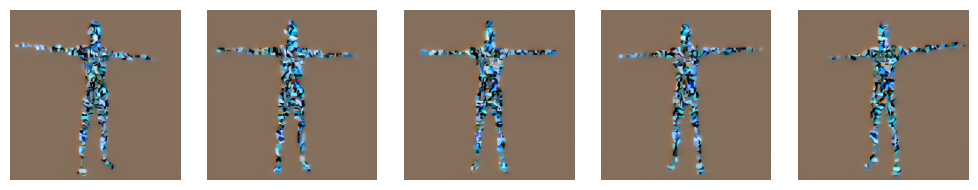

In [6]:
from text3d2video.ipython_utils import display_ims

display_ims(video_frames)

In [7]:
display_vid(pil_frames_to_clip(video_frames))

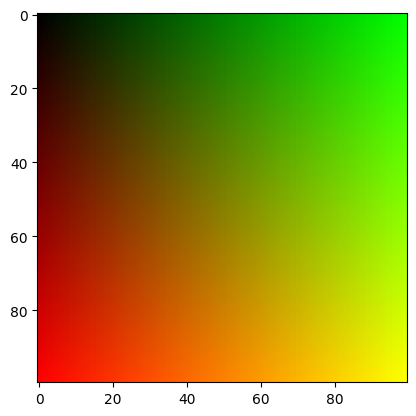

In [10]:
import matplotlib.pyplot as plt

from text3d2video.backprojection import project_visible_texels_to_camera

tex_res = 100
xs = torch.linspace(0, 1, tex_res)
ys = torch.linspace(0, 1, tex_res)

texel_xys = []
texel_uvs = []
for cam, view_mesh in zip(frame_cams, frame_meshes):
    xys, uvs = project_visible_texels_to_camera(
        view_mesh, cam, verts_uvs, faces_uvs, tex_res, raster_res=2000
    )
    texel_xys.append(xys)
    texel_uvs.append(uvs)

X, Y = torch.meshgrid(xs, ys)
uv_tex = torch.stack([X, Y], dim=-1).to(device)
zero_channel = torch.zeros_like(X).unsqueeze(-1).to(device)
uv_tex = torch.cat([uv_tex, zero_channel], dim=-1)

plt.imshow(uv_tex.cpu().numpy())

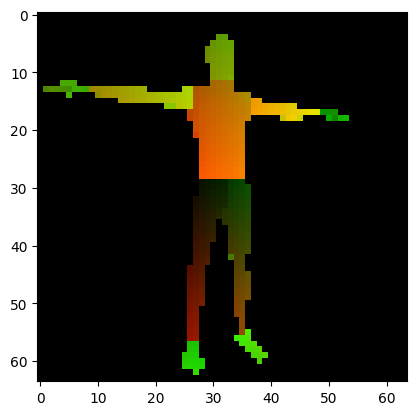

In [22]:
from text3d2video.backprojection import update_uv_texture
from text3d2video.rendering import (
    TextureShader,
    make_mesh_rasterizer,
    make_repeated_uv_texture,
)
from pytorch3d.renderer import MeshRenderer


rasterizer = make_mesh_rasterizer(resolution=64)
shader = TextureShader()
renderer = MeshRenderer(rasterizer=rasterizer, shader=shader)

mesh = frame_meshes[0]
cam = frame_cams[0]
tex = make_repeated_uv_texture(uv_tex, faces_uvs, verts_uvs)
mesh.textures = tex

render = renderer(mesh, cameras=cam)

plt.imshow(render[0].cpu().permute(1, 2, 0))

update_uv_texture(uv_tex, render[0], texel_xys[0], texel_uvs[0])